In [76]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.chdir('/content/gdrive/My Drive/computer_vision_cs682/human_pose_estimation')

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from datasets.mpii import MPII
from models.deeppose import Deeppose
from models.losses import DeepposeLose

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Deeppose()
model.to(device)
criterion = DeepposeLose()
optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

In [3]:
batch_size = 20
n_epochs = 20
print_every = 2
test_every = 4
plot_every = 2

In [4]:
train_dataset = MPII(split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
inp, target, meta1, meta2, _ = train_dataset.__getitem__(0)
print(inp.shape, target.shape, meta1.shape, meta2.shape)
len(train_loader)

Starting loading train images ... ...
Successfully loaded 22246 train images
torch.Size([3, 256, 256]) torch.Size([32]) (16, 2) (1,)


742

In [4]:
val_dataset = MPII(split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
inp, target, meta1, meta2, _ = val_dataset.__getitem__(0)
print(inp.shape, target.shape, meta1.shape, meta2.shape)
len(val_loader)

Starting loading val images ... ...
Successfully loaded 2958 val images
torch.Size([3, 256, 256]) torch.Size([32]) torch.Size([16, 2]) torch.Size([1])


148

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Deeppose()
model.to(device)
# print(model)
inp, target, _, _ = train_dataset.__getitem__(0)
inp = inp.unsqueeze(0).to(device)
target = target.unsqueeze(0).to(device)
# inp.shape
out = model(inp)
# print(out.dtype, target.dtype, inp.dtype)
# print(out, target)
criterion = DeepposeLose()
criterion(out, target)

tensor(0.9177, device='cuda:0', grad_fn=<MseLossBackward>)

In [6]:
def train():
    model.train()
    loss = 0.0
    losses = []
    n_train = len(train_loader)
    for i, data in enumerate(tqdm(train_loader)):
        inp, target, _, _, _ = data
        inp = inp.to(device)
        target = target.to(device)
        out = model(inp)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        losses.append(loss)
        if i == 10:
            break
    return torch.stack(losses).mean().item()

In [8]:
# train()

In [7]:
def test(data_loader):
    model.eval()
    loss = 0.0
    losses = []
    n_data = len(data_loader)
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            inp, target, _, _, _ = data
            inp = inp.to(device)
            target = target.to(device)
            out = model(inp)
            loss = criterion(out, target)
            losses.append(loss)
            if i == 10:
                break
    return torch.stack(losses).mean().item()

In [10]:
# test(val_loader)


epoch:2/21, train_loss: 0.04262


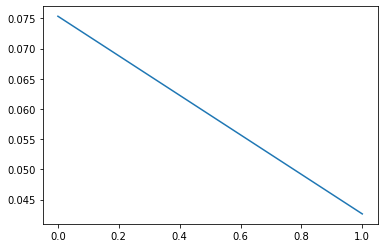


epoch:4/21, train_loss: 0.05680



epoch:4/21, val_loss: 0.04547
Updating best test loss: 0.04547


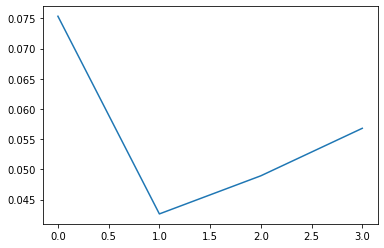


epoch:6/21, train_loss: 0.06783


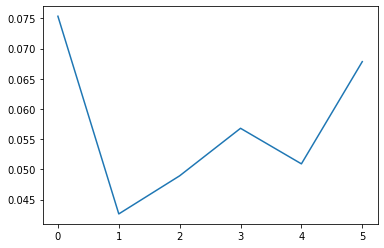


epoch:8/21, train_loss: 0.05386


KeyboardInterrupt: 

In [8]:
train_losses = []
val_losses = []
best_val_loss = np.inf
for epoch in tqdm(range(1, n_epochs+1)):
    train_loss = train()
    train_losses.append(train_loss)
    
    if epoch % print_every == 0:
        print("epoch:{}/{}, train_loss: {:.5f}".format(epoch, n_epochs+1, train_loss))
        
    if epoch % test_every == 0:
        val_loss = test(val_loader)
        print("epoch:{}/{}, val_loss: {:.5f}".format(epoch, n_epochs+1, val_loss))
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('Updating best test loss: {:.5f}'.format(best_val_loss))
            torch.save(model.state_dict(),'output_models/best_model.pth')
    if epoch % plot_every == 0:
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()

In [ ]:
print(train_losses, val_losses)

In [1]:

import os
from metrics import PCKh
import utility
from tqdm.notebook import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from datasets.mpii import MPII
from models.deeppose import Deeppose

pckh = PCKh()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Deeppose()
model.to(device)

val_dataset = MPII(split='val')
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

models = [23, 24, 30, 31, 32]
for model_no in tqdm(models):
    path = "output_models/best_model_{}.pth".format(model_no)
    model.load_state_dict(torch.load(path))
    model.eval()

    with torch.no_grad():
        mpii = val_dataset
        # using per sample image
    #     for i in tqdm(range(10)):
    #         inp, target, meta1, meta2, inp_without_clip = mpii.__getitem__(i)
    #         # print(inp.shape, target.shape, meta1.shape, meta2.shape)
    #         # raw_img, raw_pts = mpii.get_raw(0)
    #         # print(raw_img.shape, raw_pts)

    #         inp = inp.unsqueeze(0).to(device)
    #         target = target.unsqueeze(0).to(device)
    #         meta1 = meta1.unsqueeze(0).to(device)
    #         meta2 = meta2.unsqueeze(0).to(device)
    #         # print(inp.shape, target.shape, meta1.shape, meta2.shape)
    #         out = model(inp)
    #         avg_correct_joint, n_joints, ncorrect = pckh.calc_for_deeppose(out, target, meta1, meta2)
    #         print("PCKh: {:.4f}, n_joints: {}, n_correct: {}".format(avg_correct_joint, n_joints, ncorrect))

        # using val_loader
        values = []
        for i, data in enumerate(tqdm(val_loader)):
            inp, target, meta1, meta2, _ = data
            # print(inp.shape, target.shape, meta1.shape, meta2.shape)
            inp = inp.to(device)
            target = target.to(device)
            out = model(inp)
            avg_correct_joint, n_joints, ncorrect = pckh.calc_for_deeppose(out, target, meta1, meta2)
            # print(i, avg_correct_joint, n_joints, ncorrect)
            values.append(avg_correct_joint)
            # if i == 20:
            #     break
        print("PCKh for model {} is {}".format(model_no, np.mean(values)))

Starting loading val images ... ...
Successfully loaded 2958 val images



PCKh for model 23 is 0.36073096937745835



PCKh for model 24 is 0.34250933665269256



PCKh for model 30 is 0.5113377674978062



PCKh for model 31 is 0.3642947469573148



PCKh for model 32 is 0.2796289797160847

